In [1]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from scipy.stats import t
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb


from soundsig.discriminate import discriminatePlot

In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Code/songephys/'
dataPath = 'data/birds/'

birds = [
    os.path.basename(bird)
    for bird in sorted(glob.glob(os.path.join(rootPath+dataPath, "*")), key=os.path.getmtime, reverse=True)
    if (os.path.isdir(bird))]

# Color code for call type
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (255/255.0, 255/255.0, 255/255.0)}



In [3]:
# Load the data base
outPath = rootPath+dataPath+'HerminaDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()

In [4]:
dfDataBase

,bird,site,unit,stim,call,trial,R,z,PC
0,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,0,1.0,0.670113,"[-371.0872844018543, 67.70692230077798, 37.709..."
1,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,1,-1.0,-0.670113,"[-390.8290974752949, -8.252893698728801, -4.97..."
2,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,2,1.0,0.670113,"[-381.22954095551694, -11.739478782846223, 33...."
3,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,3,0.0,0.000000,"[-413.3700305165536, 19.789477797457508, 14.91..."
4,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_1_fs25k.wav,Ag,0,0.0,0.000000,"[-413.3700305165536, 19.789477797457508, 14.91..."
...,...,...,...,...,...,...,...,...,...
126662,ZF4F,ZF4F_5t_190616_102456,goodPlayback-e20-c1.pkl,WhiWhi1415_FAF_Te_5-3-1_fs25k.wav,Te,0,1.0,0.238918,"[-378.17102168090486, 12.554790689628675, 65.4..."
126663,ZF4F,ZF4F_5t_190616_102456,goodPlayback-e20-c1.pkl,WhiWhi1415_FAF_Th_3-2-5_fs25k.wav,Th,0,3.0,0.716754,"[-255.3820547782913, -75.19637820136938, 160.6..."
126664,ZF4F,ZF4F_5t_190616_102456,goodPlayback-e20-c1.pkl,WhiWhi1415_FAF_Th_3-2-5_fs25k.wav,Th,1,-1.0,-0.238918,"[-279.4208127914937, -75.99459230690728, -75.2..."
126665,ZF4F,ZF4F_5t_190616_102456,goodPlayback-e20-c1.pkl,WhiWhi1415_FAF_Th_4-1-9_fs25k.wav,Th,0,0.0,0.000000,"[-342.855105432616, 69.0482290556694, -54.1635..."


In [5]:
dfDataBaseNW = dfDataBase[dfDataBase['call'] != 'Wh']

In [8]:
# Number of Units
unitNames = np.unique(dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBaseNW['stim'][dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit]))
    # Select only Units with 110 stimuli (for now) or 97  if NW
    if (nstimsUnit[unit] == 97):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)



192


In [9]:
def naiveBayes(unitChoice, plotFlg = False, usingAllCombos = False, code='z'):
    # naiveBayes runs a guassian classifier for call types using the responses in the units in the list unitChoice
    # For now it uses the zscore in the dfDataBaseNW
    
    # Number of units
    numUnits = len(unitChoice)
    
    # Number of PCs (for PC code)
    nPCs = dfDataBaseNW['PC'][0].shape[0]
    
    # Find the unique stims played for the chosen unit
    unitIndexDict = dict()
    unitIndexLen = []
    stimList = []
    for unit in unitChoice:   
        unitIndex = dfDataBaseNW.index[dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit]
        unitIndexDict[unit] = unitIndex
        unitIndexLen.append(len(unitIndex))
        stimList.extend(list(dfDataBaseNW['stim'][unitIndex].array))
    
    stimNames = np.unique(stimList)
    
    # Generate ensemble responses  for the units in unitChoice

    # Training Trials
    rowListList = []
    totTrials = 0

    # Testing Trials
    rowListListTest = []
    totTestTrials = 0

    for stim in stimNames:
        goodStim = 2    # This means that we have at least two trials for each stim for all units
        
        # Check to see if we have enough trials for all units for this stim
        for unit in unitChoice:
            unitIndex = unitIndexDict[unit]
            unitIndexStim = [ind for ind in unitIndex if dfDataBaseNW['stim'][ind] == stim]
            if len(unitIndexStim) == 0:
                goodStim = 0
                print('Stim ', stim, 'has no response for unit', unit, '. Skipping')
                break
            elif len(unitIndexStim) == 1:
                goodStim = 1
            
        # If so continue
        if goodStim > 0 :
            rowList2Cat = []
            rowList2CatLen = []
            for unit in unitChoice:
                unitIndex = unitIndexDict[unit]
                unitIndexStim = [ind for ind in unitIndex if dfDataBaseNW['stim'][ind] == stim]
                rowList2Cat.append(unitIndexStim)
                rowList2CatLen.append(len(unitIndexStim))
            
            if goodStim > 1 :  # Use one of the responses for the test set
                listTest = []
                for iunit, unit in enumerate(unitChoice):
                    rowchosen = np.random.choice(rowList2Cat[iunit], 1, replace=False)
                    listTest.append(rowchosen[0])
                    rowList2Cat[iunit].remove(rowchosen)
                    rowList2CatLen[iunit] = len(rowList2Cat[iunit])
                rowListListTest.append(listTest)
                totTestTrials +=1
            
            if usingAllCombos:
                numSamp = np.prod(rowList2CatLen)
                totTrials += numSamp
            
                list_of_lists = []

                indUnit = np.zeros((numUnits,), dtype=int)
                indUnit[0] = -1
            
                for i in range(numSamp):
                    for iunit, unit in enumerate(unitChoice):
                        indUnit[iunit] += 1
                        if (indUnit[iunit] >= len(rowList2Cat[iunit]) ):
                            indUnit[iunit] = 0
                        else: 
                            break
                    trialList = []
                    for iunit, unit in enumerate(unitChoice):
                        trialList.append(rowList2Cat[iunit][indUnit[iunit]])
                
                    list_of_lists.append(trialList)
            else:
                numSamp = np.max(rowList2CatLen)
                totTrials += numSamp
                    
                list_of_lists = []
                for i in range(numSamp):
                    trialList = []
                    for iunit, unit in enumerate(unitChoice):
                        if i < len(rowList2Cat[iunit]):
                            trialList.append(rowList2Cat[iunit][i])
                        else:
                            trialList.append(np.random.choice(rowList2Cat[iunit], 1, replace=False)[0])
                    list_of_lists.append(trialList)
        
            rowListList.extend(list_of_lists)

    print('Total number of trials:', totTrials)
    print('Total number of test trials:', totTestTrials)
    
    # Make X (neural code), Y (call type)
    if code == 'z':
        Xfit = np.zeros((totTrials, numUnits*1))
        Xtest = np.zeros((totTestTrials, numUnits*1))
    elif code == 'PC':
        Xfit = np.zeros((totTrials, numUnits*(1+nPCs)))
        Xtest = np.zeros((totTestTrials, numUnits*(1+nPCs)))
        
    Yfit = []
    for irow,rowList in enumerate(rowListList):
        if code == 'z':
            Xfit[irow,:] = dfDataBaseNW['z'][rowList].array
        elif code == 'PC':
            Xfit[irow,:] = np.hstack([np.hstack((dfDataBaseNW['z'][ind], dfDataBaseNW['PC'][ind])) for ind in rowList])
            
        Yfit.append(np.unique(dfDataBaseNW['call'][rowList].array)[0])
    Yfit = np.array(Yfit)

    
    Ytest = []
    for irow,rowList in enumerate(rowListListTest):
        if code == 'z':
            Xtest[irow,:] = dfDataBaseNW['z'][rowList].array
        elif code == 'PC':
            Xtest[irow,:] = np.hstack([np.hstack((dfDataBaseNW['z'][ind], dfDataBaseNW['PC'][ind])) for ind in rowList])
        Ytest.append(np.unique(dfDataBaseNW['call'][rowList].array)[0])
    
    Ytest = np.array(Ytest)
    
    
    # Fit and test the classifier clf
    nClasses = len(np.unique(Yfit))

    clf = GaussianNB(priors=np.ones((nClasses,))/nClasses)
    clf.fit(Xfit,Yfit)

    probTest = clf.predict_proba(Xtest)

    # Make a confusion matrix
    confMat = np.zeros((nClasses,nClasses))
    testsPerClass = np.zeros((nClasses,))

    for i,y in enumerate(Ytest):
        classID = np.argwhere(clf.classes_ == y)
        testsPerClass[classID] += 1    
        confMat[classID,:] += probTest[i]
    
    # The confusion matrix is not normalized so that we can average it correctly later on.. 
    #for i in range(nClasses):
    #    confMat[i,:] /= testsPerClass[i]
    
    # Print percent correct classification by taking average of diagonal of confusion matrix.
    sumCorrect = np.trace(confMat)
    sumTest = np.sum(testsPerClass)
    pcc = 100.0*(sumCorrect/sumTest)
    print('PCC %.0f %%' % (pcc))
    
    if plotFlg:
        # Normalize confMat for display
        confMatNorm = np.zeros((nClasses,nClasses))
        for i in range(nClasses):
            if testsPerClass[i] > 0 :
                confMatNorm[i,:] = confMat[i,:]/testsPerClass[i]
                
        # Display comfusion matrix
        cmap='viridis'
        fig, ax = plt.subplots()
        im_ = ax.imshow(confMat*100.0, interpolation='nearest', cmap=cmap)

        fig.colorbar(im_, ax=ax)
        ax.set(xticks=np.arange(nClasses),
               yticks=np.arange(nClasses),
               xticklabels=clf.classes_,
               yticklabels=clf.classes_,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='PPC %.0f %%' % (pcc))
    
    return pcc, confMat, testsPerClass



In [10]:
# Loop through all neurons and PC 
numUnits = 1
code = 'PC'


# Choose random units
# unitChoice = np.random.choice(unitNamesFull, numUnits, replace=False)
# comb(nunitsFull, 3)
pcc = np.zeros((nunitsFull,))
confMatTot = np.zeros((ncalls, ncalls))
confMatCount = np.zeros((ncalls,))

for i,unit in enumerate(unitNamesFull):
    unitChoice = [unit]
    pcc[i], confMat, testsPerClass = naiveBayes(unitChoice, plotFlg = False, code = code)
    if (confMat.shape == (ncalls,ncalls) ) :
        confMatTot = np.add(confMatTot, confMat)
        confMatCount += testsPerClass

for i in range(ncalls):
    if confMatCount[i] > 0:
        confMatTot[i,:] = confMatTot[i,:]/confMatCount[i]

# this is to save the results of pcc for chosing only single neurons with pcc > 13
if ((numUnits == 1) & (code == 'PC')):
    # save the PC and Confusion matrices data base
    outPath = rootPath+dataPath+'HerminaDataBase1UnitPCNW.pkl'
    fileOut = open(outPath,"wb")
    pk.dump(unitNamesFull, fileOut)
    pk.dump(confMatTot, fileOut)
    pk.dump(pcc, fileOut)
    fileOut.close()


Total number of trials: 253
Total number of test trials: 97
PCC 14 %
Total number of trials: 264
Total number of test trials: 97
PCC 13 %
Total number of trials: 293
Total number of test trials: 97
PCC 21 %
Total number of trials: 271
Total number of test trials: 97
PCC 12 %
Total number of trials: 258
Total number of test trials: 96
PCC 16 %
Total number of trials: 271
Total number of test trials: 97
PCC 19 %
Total number of trials: 288
Total number of test trials: 97
PCC 14 %
Total number of trials: 353
Total number of test trials: 97
PCC 18 %
Total number of trials: 282
Total number of test trials: 96
PCC 16 %
Total number of trials: 253
Total number of test trials: 97
PCC 8 %
Total number of trials: 266
Total number of test trials: 97
PCC 14 %
Total number of trials: 290
Total number of test trials: 97
PCC 19 %
Total number of trials: 270
Total number of test trials: 97
PCC 15 %
Total number of trials: 180
Total number of test trials: 89
PCC 18 %
Total number of trials: 237
Total n

Total number of trials: 438
Total number of test trials: 97
PCC 12 %
Total number of trials: 488
Total number of test trials: 97
PCC 12 %
Total number of trials: 530
Total number of test trials: 97
PCC 13 %
Total number of trials: 479
Total number of test trials: 97
PCC 13 %
Total number of trials: 441
Total number of test trials: 97
PCC 12 %
Total number of trials: 226
Total number of test trials: 92
PCC 12 %
Total number of trials: 399
Total number of test trials: 96
PCC 14 %
Total number of trials: 316
Total number of test trials: 95
PCC 11 %
Total number of trials: 288
Total number of test trials: 95
PCC 10 %
Total number of trials: 403
Total number of test trials: 97
PCC 10 %
Total number of trials: 738
Total number of test trials: 97
PCC 12 %
Total number of trials: 336
Total number of test trials: 96
PCC 14 %
Total number of trials: 648
Total number of test trials: 97
PCC 15 %
Total number of trials: 278
Total number of test trials: 95
PCC 12 %
Total number of trials: 237
Total 

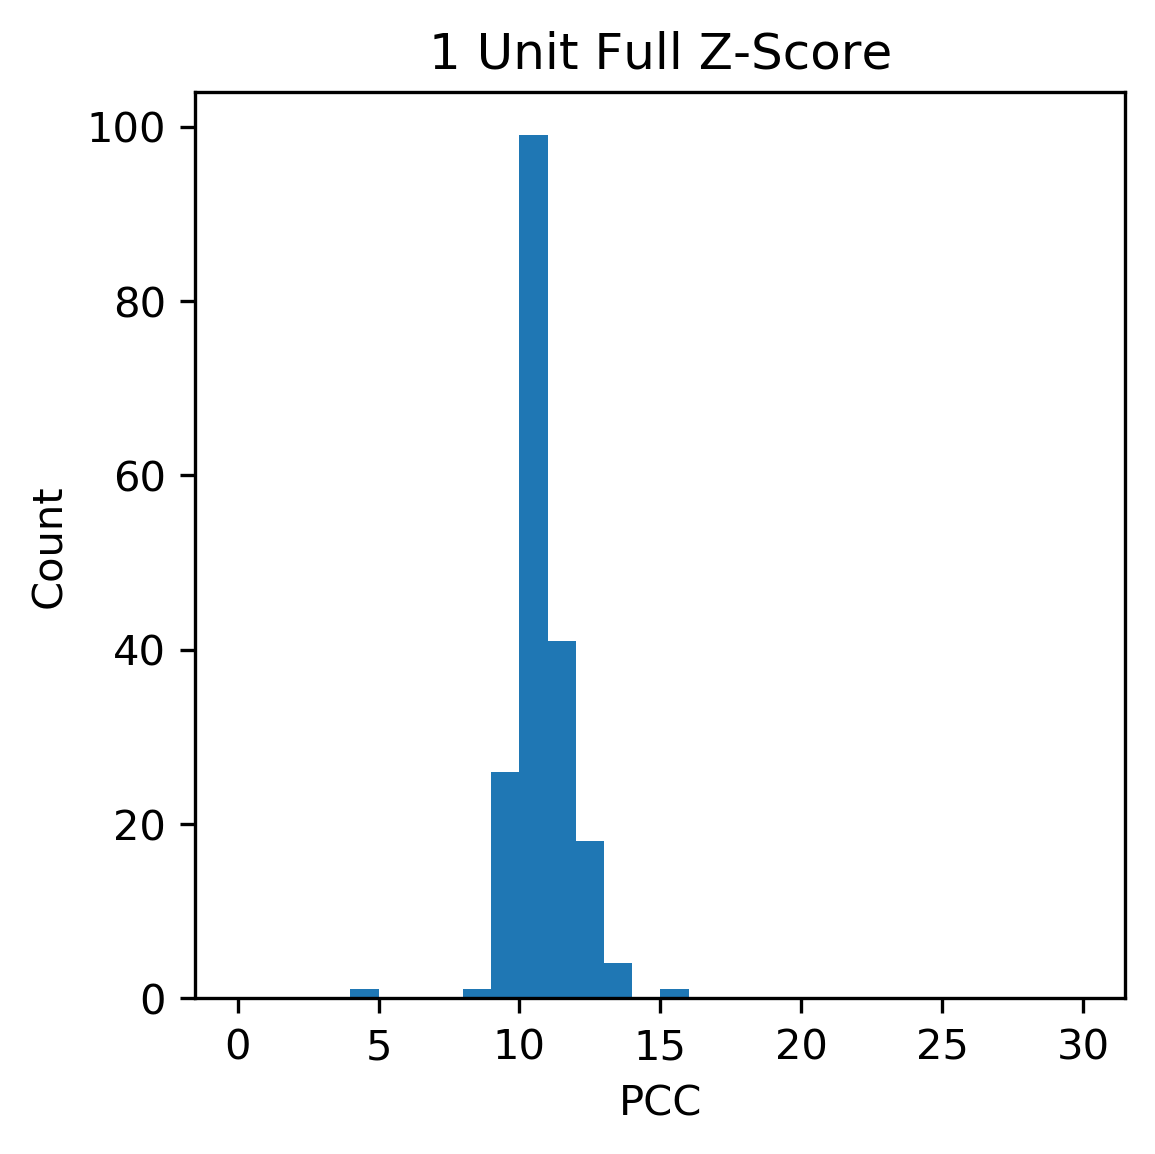

In [36]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

ax.hist(pcc, bins = 30, range = (0,30))
ax.set_xlabel('PCC')
ax.set_ylabel('Count')
ax.set_title('1 Unit Full Z-Score')

plt.savefig('/Users/frederictheunissen/Desktop/pcchist1UnitFULLZ.eps')

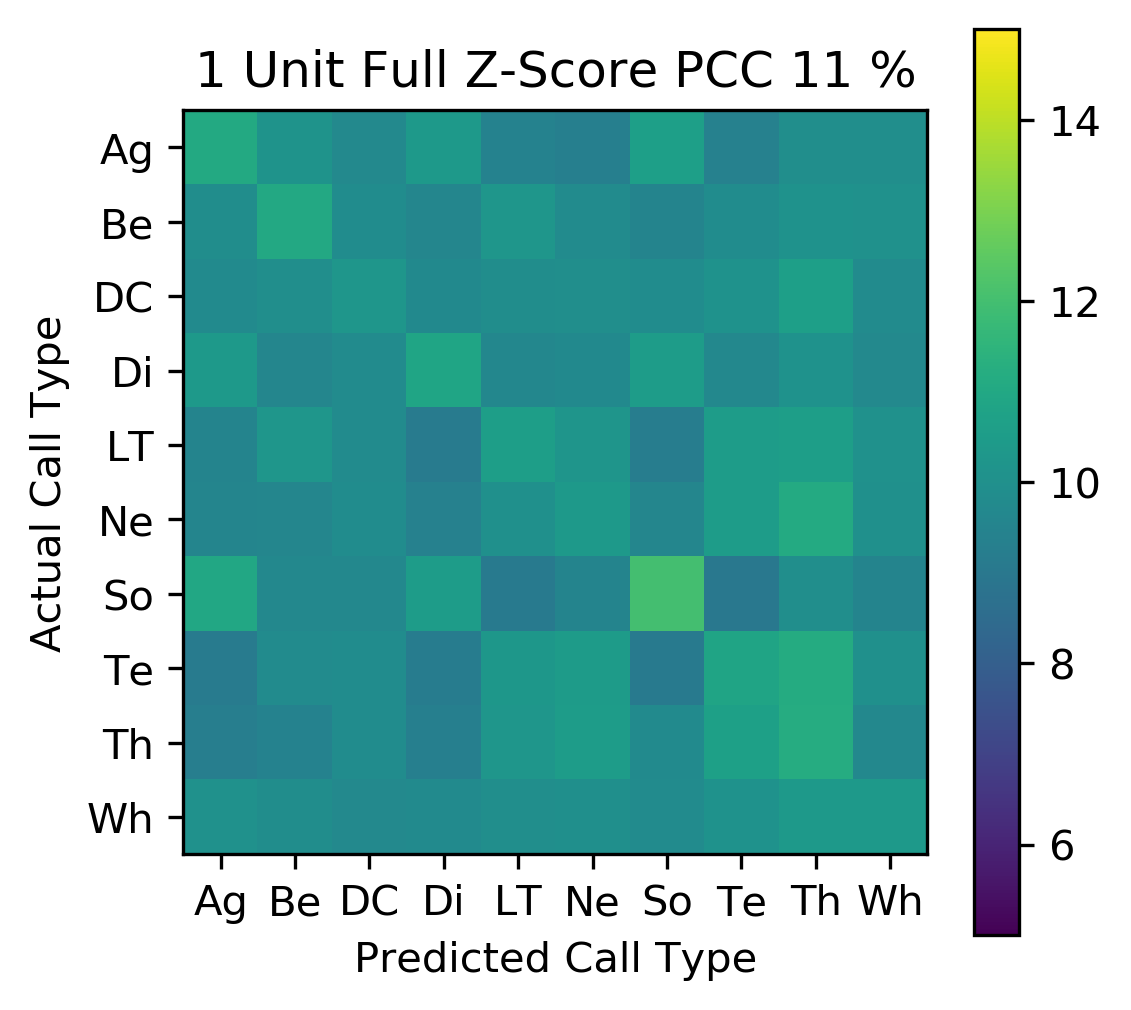

In [37]:
# Plot the overall confusion matrix

cmap='viridis'
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()
im_ = ax.imshow(confMatTot*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=5, vmax = 15)

fig.colorbar(im_, ax=ax)
ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               xticklabels=callNames,
               yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='1 Unit Full Z-Score PCC %.0f %%' % (np.mean(pcc)))

plt.savefig('/Users/frederictheunissen/Desktop/confMat1UnitFullZ.eps')
